## Qualitative Visualization Analysis of Fuji-SfM dataset
In this notebook we qualitatively analyze two different aspects of the Fuji-SfM dataset to train our models and evaluate their performance on the apple segmentation task. These two aspects are divided into the two subsections in this notebook as stated below for reference.
#### 1. Visualization of Apple Locations in the 3D Space
This visualization qualitatively helps in removing the extra tree point cloud data which helps in avoiding running the segmentation model pipeline on a highly unbalanced dataset.

#### 2. Visualization of Differently Upsampled Segmented Apple Tree Patches

This visualization helps in verifying the upsampling logic used to upsample the apple point cloud data and further look into the generated segmentation masks.

Further, with this visualization tasks we decide the extent of upsampling required for the apple class point cloud to visually or qualitatively look approximately dense as the tree point cloud data.

In [62]:
# for loading the dataset into the runtime from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# installing open3d package for visualizations and PC processing
!pip install open3d

In [64]:
# required import statements
import os
import random
import numpy as np
import open3d as o3d
from tqdm import tqdm
from os import listdir
from copy import deepcopy
from os.path import isfile, join

In [78]:
# required import statements for matplotlib
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [ ]:
# unzipping the Fuji-SfM dataset zip file
!unzip drive/MyDrive/point-cloud-prototyping/datasets/3-3D_data.zip -d .

### 0. Declaration of Constants and Utility Functions

In [66]:
# apple location annotations for training and test set in Fuji-SfM dataset
!ls 3-3D_data/GroundTruth-3D_apples_locations

test_set  training_set


In [67]:
CLS_COORD_PATH_TEST = '3-3D_data/GroundTruth-3D_apples_locations/test_set'
CLS_COORD_PATH_TRAIN = '3-3D_data/GroundTruth-3D_apples_locations/training_set'

In [4]:
# declared constants for this notebook
# TODO: update the path variables for loading these patch samples
DATA_PATH = 'drive/MyDrive/point-cloud-prototyping/datasets/fuji-sfm-dataset/train/'
FILES = ['data_patch_0_1_1.npy','data_patch_0_9_2.npy','data_patch_1_4_2.npy','data_patch_1_9_2.npy']

In [5]:
# declared constants for this notebook
TEMP_VIS_PATH = 'visualize-patches/'
TEMP_SEG_VIS_PATH = 'segment-visualize-patches/'

In [6]:
# if directory not created, create visualization directories
if not os.path.exists(TEMP_VIS_PATH):
    os.makedirs(TEMP_VIS_PATH)

if not os.path.exists(TEMP_SEG_VIS_PATH):
    os.makedirs(TEMP_SEG_VIS_PATH)

In [7]:
# PC max size for visualization for plotly
MAX_PC_SIZE = 40960 # RandLA-Net's input dimension size

In [8]:
# visualizing the segmentation map of the PC
# example dict of seg colors and their corresponding hex-values
COLOR_TO_HEX = { "green" : "#678286", "magenta" : "#E990C5",
                 "blue" : "#D8E9F7", "yellow" : "#F2D4A2",
                "red" : "#CA5047", "green" : "#689F55"}

def hex_to_rgb(hex):
  return list(round(int(hex[i:i+2], 16)/255,2) for i in (1, 3, 5))

COLOR_TO_RGB = {}

for k,v in COLOR_TO_HEX.items():
    COLOR_TO_RGB[k] = hex_to_rgb(v)

In [9]:
# procedural logic for the upsampling function

# separate out apple class sub array with rgb values
# build a KDTree of the separated out sub array
# loop over upsampling_factor number of points
# then random point selection based on index
# post that, query the nearest neighbor to that random point
# preserve rgb information, separate array for actual upsampling operation

# also, update the whole PC to create new upsampling temporary PC
# after certain number of upsampled new PC size chunk is created
# for better upsampling consistency.

def upsample_minor_class(pcl_arr, upsampling_factor):
    assert upsampling_factor >= 1.0 and upsampling_factor <= 3.0
    pcl_arr_cls = pcl_arr[pcl_arr[:,6] == 1]
    pcl_arr_bg = pcl_arr[pcl_arr[:,6] == 0]
    # open3d pcl processing
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pcl_arr_cls[:,0:3])
    # building KD-Tree for NN query
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)
    upsample_count = int((upsampling_factor - 1.0)*pcl_arr_cls.shape[0])
    # upsampled points nested list
    upsampled_points = []
    umsample_limit_flg = 0
    for i in tqdm(range(upsample_count)):
        rand_ind = random.randint(0,pcl_arr_cls.shape[0]-1) 
        [k, idx_vals, _] = pcd_tree.search_knn_vector_3d(pcd.points[rand_ind], 4)
        idx_vals = idx_vals[1:]
        rand_neighbor = random.choice(idx_vals)
        # creating new upsampled points
        arr_vals = (pcl_arr_cls[rand_ind] + pcl_arr_cls[rand_neighbor]) / 2
        upsampled_points.append(list(arr_vals))
        if len(upsampled_points) > 0.8 * pcl_arr_cls.shape[0] and umsample_limit_flg == 0:
            pcl_arr_cls =  np.concatenate((pcl_arr_cls, np.array(upsampled_points)), axis=0)
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(pcl_arr_cls[:,0:3])
            # building KD-Tree for NN query
            pcd_tree = o3d.geometry.KDTreeFlann(pcd)
            umsample_limit_flg = 1
            upsampled_points = []

    pcl_arr_cls =  np.concatenate((pcl_arr_cls, np.array(upsampled_points)), axis=0)
    pcl_arr_final = np.concatenate((pcl_arr_cls, pcl_arr_bg), axis=0)
    return pcl_arr_final

In [10]:
# downsampling the PC size for standardization of visualized 'cls' & 'bg' PC size
def downsample_pcl(pcl_arr, downsampling_factor):
    assert downsampling_factor >= 0.2 and downsampling_factor < 1.0
    downsampled_pc_count = int(downsampling_factor * pcl_arr.shape[0])
    if downsampled_pc_count > MAX_PC_SIZE:
        downsampled_pc_count = MAX_PC_SIZE
    idx_cls = np.random.randint((pcl_arr.shape[0] - 1),
                                size = downsampled_pc_count)
    pcl_arr = pcl_arr[idx_cls,:] 
    return pcl_arr

In [11]:
# saving the downsampled PC for visualization with open3d and plotly
def save_rgb_txt(pc_arr, complete_path):
    pc_arr = deepcopy(pc_arr)
    pc_arr = pc_arr[:,:6]
    pc_arr[:,3:6] = pc_arr[:,3:6]/255
    pc_arr = downsample_pcl(pc_arr, downsampling_factor = 0.5)
    np.savetxt(complete_path, pc_arr, delimiter=' ')

In [12]:
# saving the downsampled segmented PC for visualization with open3d and plotly
# function to load the npy array and convert to '.txt' readable
# format of open3d's draw_plotly function
def segmap_color_generator(pc_arr, save_path):
    data_patch = deepcopy(pc_arr)
    data_patch = downsample_pcl(data_patch,
                                     downsampling_factor = 0.5)
    data_patch_list = list(data_patch)
    seg_map_list = []
    class_colors_list = COLOR_TO_RGB['red']
    bg_colors_list = COLOR_TO_RGB['green']
    for vals in data_patch_list:
        if vals[6] == 1:
            joined_temp_list = list(vals[:3]) + class_colors_list
            seg_map_list.append(joined_temp_list)
        else:
            joined_temp_list = list(vals[:3]) + bg_colors_list
            seg_map_list.append(joined_temp_list)
    
    seg_map = np.array(seg_map_list)
    

    np.savetxt(save_path, seg_map, delimiter=' ')

In [13]:
# visualization of the stored PC files 
def viz_pcl_o3d(pcl_txt_path):
    pcd_viz = o3d.io.read_point_cloud(pcl_txt_path, format='xyzrgb')
    o3d.visualization.draw_plotly([pcd_viz])

### 1. Visualization of Apple Locations in 3D Space

In [69]:
# train and test bounding box coordinate values for the apples
cls_coord_files_test = [f for f in listdir(CLS_COORD_PATH_TEST) if isfile(join(CLS_COORD_PATH_TEST, f))]
print(cls_coord_files_test[:5])
cls_coord_files_train = [f for f in listdir(CLS_COORD_PATH_TRAIN) if isfile(join(CLS_COORD_PATH_TRAIN, f))]
print(cls_coord_files_train[:5])

['Tree03-annotations_000116.txt', 'Tree08-annotations_000149.txt', 'Tree07-annotations_000073.txt', 'Tree04-annotations_000006.txt', 'Tree03-annotations_000075.txt']
['Tree11-annotations_000118.txt', 'Tree11-annotations_000070.txt', 'Tree11-annotations_000082.txt', 'Tree10-annotations_000080.txt', 'Tree11-annotations_000011.txt']


In [72]:
# defining list for storing bounding box coordinates
cls_bb_box_coord_lst = []
# reader loop for test set bounding box annotations 
for bb_test_file in cls_coord_files_test:
    bb_test_arr = np.loadtxt(CLS_COORD_PATH_TEST+'/'+bb_test_file)
    cls_bb_box_coord_lst.append(bb_test_arr[1].tolist())
# reader loop for train set bounding box annotations
for bb_train_file in cls_coord_files_train:
    bb_train_arr = np.loadtxt(CLS_COORD_PATH_TRAIN+'/'+bb_train_file)
    cls_bb_box_coord_lst.append(bb_train_arr[1].tolist())

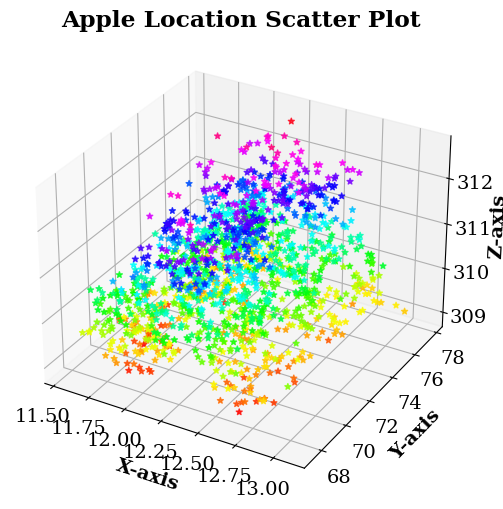

In [102]:
# plotting apple center coordinates
def plot_cls_coordinates(bb_coords_list):
    matplotlib.rcParams.update({'font.size': 14})
    matplotlib.rcParams.update({'font.family': 'serif'})
    bb_coords_list = np.array(bb_coords_list)
    # Creating figure
    fig = plt.figure(figsize = (6, 6))
    ax = plt.axes(projection ="3d")
    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.3,
            alpha = 0.2)
    # Creating color map
    my_cmap = plt.get_cmap('hsv')
    # Creating plot
    sctt = ax.scatter3D(bb_coords_list[:,0],
                        bb_coords_list[:,1],
                        bb_coords_list[:,2],
                        alpha = 0.8,
                        c = (bb_coords_list[:,2]),
                        cmap = my_cmap,
                        marker ='*')
    plt.title("Apple Location Scatter Plot", fontweight ='bold')
    ax.set_xlabel('X-axis', fontweight ='bold', labelpad = 5)
    ax.set_ylabel('Y-axis', fontweight ='bold', labelpad = 5)
    ax.set_zlabel('Z-axis', fontweight ='bold', labelpad = 2)
    # fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
    # show plot
    plt.show()

plot_cls_coordinates(cls_bb_box_coord_lst)

### 2. Visualizing Differently Upsampled Segmentation Masks

In [14]:
# loading point cloud data patches in numpy arrays
data_patch_one = np.load(DATA_PATH + FILES[0])
data_patch_two = np.load(DATA_PATH + FILES[1])
data_patch_three = np.load(DATA_PATH + FILES[2])
data_patch_four = np.load(DATA_PATH + FILES[3])

In [ ]:
# calculating percentage of apple and background tree PC size for all patches
unq_patch_one, cnt_patch_one = np.unique(data_patch_one[:,6],
                                         return_counts=True)
unq_patch_two, cnt_patch_two = np.unique(data_patch_two[:,6],
                                         return_counts=True)
unq_patch_three, cnt_patch_three = np.unique(data_patch_three[:,6],
                                         return_counts=True)
unq_patch_four, cnt_patch_four = np.unique(data_patch_four[:,6],
                                         return_counts=True)

# apple class and background class PC fractional occupancy in a given patch
print(cnt_patch_one[0]/data_patch_one.shape[0], # background class label
      cnt_patch_one[1]/data_patch_one.shape[0]) # apple class label
print(cnt_patch_two[0]/data_patch_two.shape[0], # background class label
      cnt_patch_two[1]/data_patch_two.shape[0]) # apple class label
print(cnt_patch_three[0]/data_patch_three.shape[0], # background class label
      cnt_patch_three[1]/data_patch_three.shape[0]) # apple class label
print(cnt_patch_four[0]/data_patch_four.shape[0], # background class label
      cnt_patch_four[1]/data_patch_four.shape[0]) # apple class label

#### **Observations and Comments**
#### **1.** Point cloud size percentage occupancy varies from 25 % to 50 % in the above data patches under analysis.
#### **2.** The edge case patches will be further visualized with different upsampling factors for segmentation mask observations. Based on this qualitative visualization an additional patch pre-processing step will be added for model training.

#### **Note:** The PC for apple class is already upsampled in the foundation PC array before the patch generation where it amounts to 19.6 % of the cropped foundation PC from the original 4.6 % of the complete original PC Fuji-SfM dataset.

In [ ]:
# upsampling the point cloud the PC data patches for visualization
data_patch_one_dubl = upsample_minor_class(data_patch_one, upsampling_factor = 2)
data_patch_one_trpl = upsample_minor_class(data_patch_one, upsampling_factor = 3)

data_patch_four_dubl = upsample_minor_class(data_patch_four, upsampling_factor = 2)
data_patch_four_trpl = upsample_minor_class(data_patch_four, upsampling_factor = 3)

In [17]:
# calculating percentage of 'cls' and 'bg' tree PC size for upsampled patches
unq_patch_one_dubl, cnt_patch_one_dubl = np.unique(data_patch_one_dubl[:,6],
                                         return_counts=True)
unq_patch_one_trpl, cnt_patch_one_trpl = np.unique(data_patch_one_trpl[:,6],
                                         return_counts=True)
unq_patch_four_dubl, cnt_patch_four_dubl = np.unique(data_patch_four_dubl[:,6],
                                         return_counts=True)
unq_patch_four_trpl, cnt_patch_four_trpl = np.unique(data_patch_four_trpl[:,6],
                                         return_counts=True)

In [ ]:
# apple class and background class PC fractional occupancy in upsampled patches
print(cnt_patch_one_dubl[0]/data_patch_one_dubl.shape[0], # background class label
      cnt_patch_one_dubl[1]/data_patch_one_dubl.shape[0]) # apple class label
print(cnt_patch_one_trpl[0]/data_patch_one_trpl.shape[0], # background class label
      cnt_patch_one_trpl[1]/data_patch_one_trpl.shape[0]) # apple class label
print(cnt_patch_four_dubl[0]/data_patch_four_dubl.shape[0], # background class label
      cnt_patch_four_dubl[1]/data_patch_four_dubl.shape[0]) # apple class label
print(cnt_patch_four_trpl[0]/data_patch_four_trpl.shape[0], # background class label
      cnt_patch_four_trpl[1]/data_patch_four_trpl.shape[0]) # apple class label

In [31]:
# saving visualization files in txt form with rgb color info
save_rgb_txt(data_patch_one, TEMP_VIS_PATH + 'org_' + FILES[0].split('.')[0]+'.txt')
save_rgb_txt(data_patch_one_dubl, TEMP_VIS_PATH + 'dubl_' + FILES[0].split('.')[0]+'.txt')
save_rgb_txt(data_patch_one_trpl, TEMP_VIS_PATH + 'trpl_' + FILES[0].split('.')[0]+'.txt')

In [32]:
# saving visualization files in txt form with rgb color info
save_rgb_txt(data_patch_four, TEMP_VIS_PATH + 'org_' + FILES[3].split('.')[0]+'.txt')
save_rgb_txt(data_patch_four_dubl, TEMP_VIS_PATH + 'dubl_' + FILES[3].split('.')[0]+'.txt')
save_rgb_txt(data_patch_four_trpl, TEMP_VIS_PATH + 'trpl_' + FILES[3].split('.')[0]+'.txt')

In [52]:
# saving visualization files in txt form with segmentation color info
segmap_color_generator(data_patch_one,
                       TEMP_SEG_VIS_PATH + 'org_' + FILES[0].split('.')[0]+'.txt')
segmap_color_generator(data_patch_one_dubl,
                       TEMP_SEG_VIS_PATH + 'dubl_' + FILES[0].split('.')[0]+'.txt')
segmap_color_generator(data_patch_one_trpl,
                       TEMP_SEG_VIS_PATH + 'trpl_' + FILES[0].split('.')[0]+'.txt')

In [34]:
# saving visualization files in txt form with segmentation color info
segmap_color_generator(data_patch_four,
                       TEMP_SEG_VIS_PATH + 'org_' + FILES[3].split('.')[0]+'.txt')
segmap_color_generator(data_patch_four_dubl,
                       TEMP_SEG_VIS_PATH + 'dubl_' + FILES[3].split('.')[0]+'.txt')
segmap_color_generator(data_patch_four_trpl,
                       TEMP_SEG_VIS_PATH + 'trpl_' + FILES[3].split('.')[0]+'.txt')

In [ ]:
# list of saved patches with rgb color info
!ls visualize-patches/

In [ ]:
# list of saved patches with rgb color info
!ls segment-visualize-patches/

In [ ]:
# visualizing colored point cloud for first data patch sample
viz_pcl_o3d(TEMP_VIS_PATH + 'org_' + FILES[0].split('.')[0]+'.txt')

In [ ]:
viz_pcl_o3d(TEMP_VIS_PATH + 'dubl_' + FILES[0].split('.')[0]+'.txt')

In [ ]:
viz_pcl_o3d(TEMP_VIS_PATH + 'trpl_' + FILES[0].split('.')[0]+'.txt')

In [ ]:
# visualizing colored point cloud for second data patch sample
viz_pcl_o3d(TEMP_VIS_PATH + 'org_' + FILES[3].split('.')[0]+'.txt')

In [ ]:
viz_pcl_o3d(TEMP_VIS_PATH + 'dubl_' + FILES[3].split('.')[0]+'.txt')

In [ ]:
viz_pcl_o3d(TEMP_VIS_PATH + 'trpl_' + FILES[3].split('.')[0]+'.txt')

In [ ]:
# visualizing segmented point cloud for second data patch sample
viz_pcl_o3d(TEMP_SEG_VIS_PATH + 'org_' + FILES[0].split('.')[0]+'.txt')

In [ ]:
viz_pcl_o3d(TEMP_SEG_VIS_PATH + 'dubl_' + FILES[0].split('.')[0]+'.txt')

In [ ]:
viz_pcl_o3d(TEMP_SEG_VIS_PATH + 'trpl_' + FILES[0].split('.')[0]+'.txt')

In [ ]:
# visualizing segmented point cloud for second data patch sample
viz_pcl_o3d(TEMP_SEG_VIS_PATH + 'org_' + FILES[3].split('.')[0]+'.txt')

In [ ]:
viz_pcl_o3d(TEMP_SEG_VIS_PATH + 'dubl_' + FILES[3].split('.')[0]+'.txt')

In [ ]:
viz_pcl_o3d(TEMP_SEG_VIS_PATH + 'trpl_' + FILES[3].split('.')[0]+'.txt')